In [1]:
workdir = "/SNS/users/lj7/dv/sns-chops/detcalib/SEQ"
%cd {workdir}

/SNS/users/lj7/dv/sns-chops/detcalib/SEQ


In [2]:
import sys, os, numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook

In [3]:
sys.path.insert(0, "%s/lib"%workdir)

In [4]:
#sys.path

In [5]:
import get_I_tof
reload(get_I_tof)

<module 'get_I_tof' from '/SNS/users/lj7/dv/sns-chops/detcalib/SEQ/lib/get_I_tof.pyc'>

In [6]:
import get_difc_from_Itof
reload(get_difc_from_Itof)

<module 'get_difc_from_Itof' from '/SNS/users/lj7/dv/sns-chops/detcalib/SEQ/lib/get_difc_from_Itof.pyc'>

In [7]:
import align
reload(align)
import align_utils
reload(align_utils)

<module 'align_utils' from '/SNS/users/lj7/dv/sns-chops/detcalib/SEQ/lib/align_utils.pyc'>

In [53]:
pack = 'C25T/eightpack'
packname, packtype = pack.split('/')

# C60

## Obtain I(tof) curves for all pixels and save them

** skip this if already done !!! **

In [ ]:
%%time
nxs_files = ['/SNS/SEQ/IPTS-19573/nexus/SEQ_130273.nxs.h5']
init_IDF = './SEQUOIA_Definition.xml'
outdir = 'Si-I_tof'
packs = [pack]
get_I_tof.get_I_tof(nxs_files, outdir, packs, dt = 1000., tofaxis=(500,1.e6/60/2.*1.05, -0.005))

In [9]:
# np.load('Si-I_tof/I_tof-xbb.npy')

In [54]:
ls C60-I_tof/*{packname}*

C60-I_tof/difc-C25T.npy     C60-I_tof/mask-C25T.npy
C60-I_tof/I_tof-y-C25T.npy  C60-I_tof/pack-C25T.yaml


In [55]:
cat C60-I_tof/pack-{packname}.yaml

pixelIDs:
  first: 100352
  last: 101375


<IPython.core.display.Javascript object>


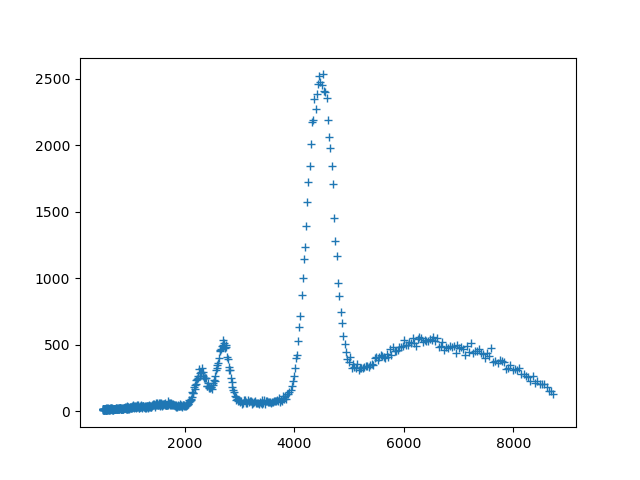

In [56]:
xbb = np.load('C60-I_tof/I_tof-xbb.npy')
x = (xbb[:-1] + xbb[1:])/2
ypack = np.load('C60-I_tof/I_tof-y-%s.npy' % packname)
plt.figure()
plt.plot(x, ypack[60], '+')

## Obtain difc

In [57]:
reload(get_difc_from_Itof)

<module 'get_difc_from_Itof' from '/SNS/users/lj7/dv/sns-chops/detcalib/SEQ/lib/get_difc_from_Itof.pyc'>

In [58]:
def T0_E(E, bg, A, power, E_decay):
    return bg + A*E**power*np.exp(-E/E_decay)
SEQ_T0_of_E = lambda E: T0_E(E, bg=0, A=54.881, power=-0.21413, E_decay=194.4)
# SEQ_T0_of_E = lambda E: T0_E(E, bg=-330, A=54.881*26, power=-0.21413, E_decay=194.4)

In [59]:
fitter = get_difc_from_Itof.Fitter(peak_fractional_width=0.02, bg_type='linear', t0_range=(0, 0.01))
dvalues = [2.72509327,  2.89039789, 4.26940063,  5.00631601, 8.17527981]
dmin=6; dmax=10

In [60]:
I_tof_dir = 'C60-I_tof'

In [61]:
def load_L2_from_nxs(path):
    "load L2 computed using mantid and saved as nxs"
    from mantid import simpleapi as msa
    L2_calib = msa.Load(path)
    L2_calib = msa.SortTableWorkspace(L2_calib, Columns='detid')
    L2 = np.array(L2_calib.column('L2'))
    L2_detID = np.array(L2_calib.column('detid'))
    nodata = np.array(L2_calib.column('nodata'), dtype=bool)
    return L2
L2 = load_L2_from_nxs('./L2table.nxs')

detIDs = np.load('%s/detIDs.npy' % I_tof_dir)
detID_list = list(detIDs)

import yaml
packinfo = yaml.load(open(os.path.join( I_tof_dir, 'pack-%s.yaml' % packname)))
firstpixelID = packinfo['pixelIDs']['first']
firstpixel_index = detID_list.index(firstpixelID)
L2_pack = L2[firstpixel_index: firstpixel_index+1024]

In [66]:

gpd = get_difc_from_Itof.GetPackDifc(
    pack=packname,
    dvalues=dvalues,
    dmin=dmin, dmax=dmax,
    I_tof_dir = I_tof_dir,
    fitter=fitter,
    maxchisq = 150,
    min_counts = 10000,
    T0_of_E=SEQ_T0_of_E,
    L2 = L2_pack,
)

* tof range: 2083.33333333 8333.33333333


2.8135263071
448.079384707 436.337333672 1.57641020626e-14


<IPython.core.display.Javascript object>


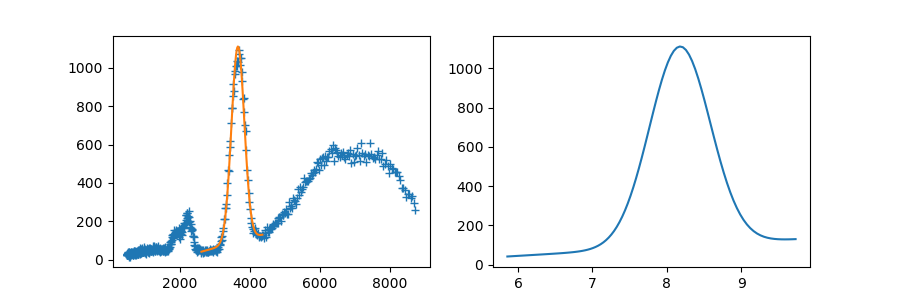

CPU times: user 301 ms, sys: 47.2 ms, total: 349 ms
Wall time: 333 ms


In [63]:
%%time
fitres = gpd.fitOnePixel(34+128*7)
print fitres.chisq
print fitres.difc, fitres.nominal_difc, fitres.t0
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.plot(fitres.plotdata.x,fitres.plotdata.y, '+')
plt.plot(fitres.plotdata.fitx, fitres.plotdata.fity)
plt.subplot(1,2,2)
plt.plot(fitres.plotdata.d, fitres.plotdata.fity)

In [19]:
ds = np.array(fitres.params.dvalues[::-1])
peakcounts = fitres.popt[-2::-2] [:len(ds)]
print np.sum(ds*peakcounts)/np.sum(peakcounts)

4.26940063


392.693705791
633.504546802 615.05295806 0.01


<IPython.core.display.Javascript object>


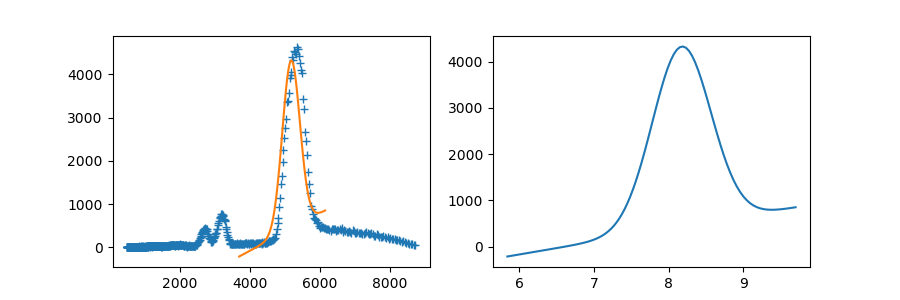

CPU times: user 263 ms, sys: 35.2 ms, total: 298 ms
Wall time: 272 ms


In [64]:
%%time
fitres = gpd.fitOnePixel(110+128*7)
print fitres.chisq
print fitres.difc, fitres.nominal_difc, fitres.t0
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.plot(fitres.plotdata.x,fitres.plotdata.y, '+')
plt.plot(fitres.plotdata.fitx, fitres.plotdata.fity)
plt.subplot(1,2,2)
plt.plot(fitres.plotdata.d, fitres.plotdata.fity)

In [21]:
ds = np.array(fitres.params.dvalues[::-1])
peakcounts = fitres.popt[-2::-2] [:len(ds)]
print np.sum(ds*peakcounts)/np.sum(peakcounts)

4.26940063


In [67]:
%%time
Si_difc, Si_mask, Si_signature_d = gpd()

- Working on pixel 0
.* Not enough counts: 0
* fit failed: pixel 0
.* Not enough counts: 1
* fit failed: pixel 1
.* Not enough counts: 2
* fit failed: pixel 2
.* Not enough counts: 3
* fit failed: pixel 3
.* Not enough counts: 4
* fit failed: pixel 4
.* Not enough counts: 5
* fit failed: pixel 5
..............................................................................................- Working on pixel 100
..* chisq too large: pixel 101, chisq 151.179900756
.* chisq too large: pixel 102, chisq 160.193580144
.* chisq too large: pixel 103, chisq 163.658464485
.* chisq too large: pixel 104, chisq 177.0516237
.* chisq too large: pixel 105, chisq 180.484452653
.* chisq too large: pixel 106, chisq 180.313996143
.* chisq too large: pixel 107, chisq 198.867924888
.* chisq too large: pixel 108, chisq 196.542707957
.* chisq too large: pixel 109, chisq 204.170749501
.* chisq too large: pixel 110, chisq 206.857798025
.* chisq too large: pixel 111, chisq 210.931568074
.* chisq too large: pixel 

.* Not enough counts: 773
* fit failed: pixel 773
.* Not enough counts: 774
* fit failed: pixel 774
.........................- Working on pixel 800
...........................................................* chisq too large: pixel 858, chisq 167.865153257
.* chisq too large: pixel 859, chisq 177.658419546
.* chisq too large: pixel 860, chisq 180.236020541
.* chisq too large: pixel 861, chisq 188.725234783
.* chisq too large: pixel 862, chisq 215.738662774
.* chisq too large: pixel 863, chisq 218.50740305
.* chisq too large: pixel 864, chisq 220.865416663
.* chisq too large: pixel 865, chisq 239.91588769
.* chisq too large: pixel 866, chisq 247.069552782
.* chisq too large: pixel 867, chisq 262.107734578
.* chisq too large: pixel 868, chisq 276.640755838
.* chisq too large: pixel 869, chisq 288.980510801
.* chisq too large: pixel 870, chisq 297.713595427
.* chisq too large: pixel 871, chisq 305.631450719
.* chisq too large: pixel 872, chisq 307.456393016
.* chisq too large: pixel 873, 

<IPython.core.display.Javascript object>


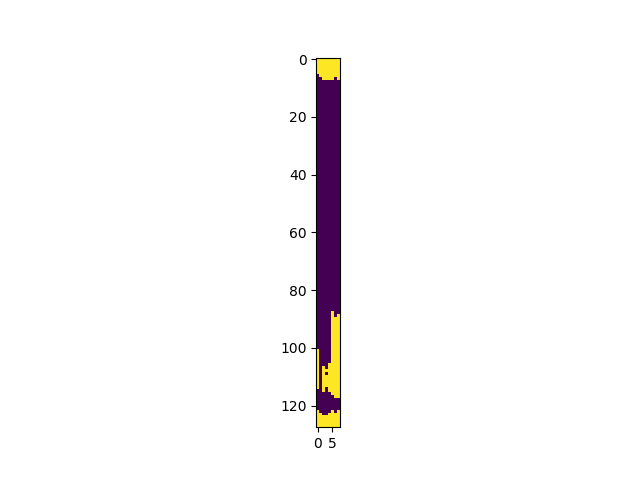

In [68]:
view = Si_mask.view()
view.shape = 8, 128
plt.figure()
plt.imshow(view.T)

In [24]:
np.save(os.path.join(I_tof_dir, 'difc-%s.npy' % packname), Si_difc)
np.save(os.path.join(I_tof_dir, 'mask-%s.npy' % packname), Si_mask)

In [25]:
#I_tof_dir = 'Si-I_tof' 
#Si_difc = np.load(os.path.join(I_tof_dir, 'difc-%s.npy' % packname))
#Si_mask = np.load(os.path.join(I_tof_dir, 'mask-%s.npy' % packname))

In [26]:
I_tof_dir = 'Si-I_tof' 
!ls {I_tof_dir}/*-{packname}.npy

Si-I_tof/difc-D25.npy  Si-I_tof/I_tof-y-D25.npy  Si-I_tof/mask-D25.npy


# Align

In [69]:
alignment = align.Align('./C60-I_tof')
# alignment.options['Xposition'] = (-.025, .025)
# alignment.options['Yposition'] = (-.025, .025)

In [70]:
alignment.load_L2_from_nxs('./L2table.nxs')

(array([-1.        , -1.        , -1.        , ...,  5.68382549,
         5.69823694,  5.67509985]),
 array([ True,  True,  True, ..., False, False, False], dtype=bool))

In [74]:
%%time
alignment.align(
    Si_difc, Si_mask, packname, ofile=open('new-%s.xml' % packname, 'wt'),
    params0 = [0.06600619612, 0.44, 5.50764222828, -178.16963756000004, 0.0, -0.0],
)

2017-12-13 14:54:45,685 - Align component - INFO - Working on init_IDF.xml/C row/C25T/eightpack-top. Starting position is [0.06600619612, 0.431673, 5.50764222828], Starting rotation is [-178.16963756000004, 0.0, -0.0]
2017-12-13 14:54:45,685 - Align component - INFO - Working on init_IDF.xml/C row/C25T/eightpack-top. Starting position is [0.06600619612, 0.431673, 5.50764222828], Starting rotation is [-178.16963756000004, 0.0, -0.0]
2017-12-13 14:54:45,685 - Align component - INFO - Working on init_IDF.xml/C row/C25T/eightpack-top. Starting position is [0.06600619612, 0.431673, 5.50764222828], Starting rotation is [-178.16963756000004, 0.0, -0.0]
2017-12-13 14:54:45,685 - Align component - INFO - Working on init_IDF.xml/C row/C25T/eightpack-top. Starting position is [0.06600619612, 0.431673, 5.50764222828], Starting rotation is [-178.16963756000004, 0.0, -0.0]


- Working on C25T
- pack params: [0.06600619612, 0.431673, 5.50764222828, -178.16963756000004, 0.0, -0.0]
[[False False False False False False False False]
 [False False False False False False False False]]
center twotheta:  0.0813284781328
* initial parameters:  [0.06600619612, 0.44, 5.50764222828, -178.16963756000004, 0.0, -0.0]
0.000111353205248
0.000111353211887
0.000111353211931
0.00011135320525
0.000110533474707
0.000110533479323
0.000110533481379
0.000110533474709
0.000106315257108
0.000106315254338
0.000106315260036
0.000106315257108
0.000105811358598
0.000105811359614
0.000105811358096
0.000105811358598
0.000105790880335
0.000105790880342
0.000105790880336


2017-12-13 14:55:04,276 - Align component - INFO - Finished optimizing init_IDF.xml/C row/C25T/eightpack-top. Final position is [0.061691326929749046, 0.44, 5.495326684721679], Final rotation is [-178.16964053633922, 0.0, 0.0]
2017-12-13 14:55:04,276 - Align component - INFO - Finished optimizing init_IDF.xml/C row/C25T/eightpack-top. Final position is [0.061691326929749046, 0.44, 5.495326684721679], Final rotation is [-178.16964053633922, 0.0, 0.0]
2017-12-13 14:55:04,276 - Align component - INFO - Finished optimizing init_IDF.xml/C row/C25T/eightpack-top. Final position is [0.061691326929749046, 0.44, 5.495326684721679], Final rotation is [-178.16964053633922, 0.0, 0.0]
2017-12-13 14:55:04,276 - Align component - INFO - Finished optimizing init_IDF.xml/C row/C25T/eightpack-top. Final position is [0.061691326929749046, 0.44, 5.495326684721679], Final rotation is [-178.16964053633922, 0.0, 0.0]


0.000105790880335
- Estimate: (0.12317396413896847, 0.431673, 5.5074469533851502)
- New: [0.061691326929749046, 0.44, 5.495326684721679, -178.16964053633922, 0.0, 0.0]

  <type name="C25T">
    <component type="eightpack-top">
      <location x="0.06169133" y="0.44000000" z="5.49532668">
         <rot axis-z="0" axis-x="0" axis-y="1" val="-178.16964054"/>
      </location>
    </component>
  </type>

CPU times: user 19.3 s, sys: 289 ms, total: 19.6 s
Wall time: 19.4 s


([0.061691326929749046,
  0.44,
  5.495326684721679,
  -178.16964053633922,
  0.0,
  0.0],
 <align_utils.FitPack_DifcL2 at 0x7f48b27f49d0>)

# Debug

In [46]:
init_center = [0.06600619612, -0.468884, 5.50764222828, ]
init_beta =   -178.16963756000004
pixel_height = 0.0046875*2
print pixel_height*128
tube_spacing = 0.013716*2
print tube_spacing*7

1.2
0.192024


In [47]:
reload(align_utils)

<module 'align_utils' from '/SNS/users/lj7/dv/sns-chops/detcalib/SEQ/lib/align_utils.pyc'>

[[False False False False False False False False]
 [False False False False False False False False]]
center twotheta:  0.0852218162514


<IPython.core.display.Javascript object>


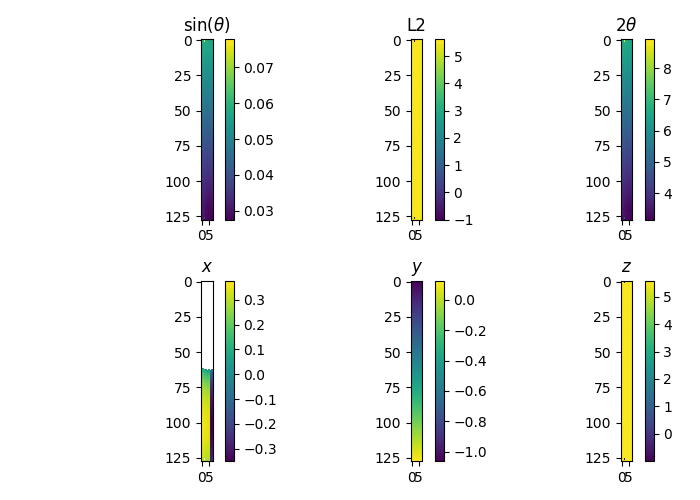

/SNS/users/lj7/dv/sns-chops/detcalib/SEQ/lib/align_utils.py:431: RuntimeWarning:

invalid value encountered in sqrt



In [48]:
pack_x1, pack_y1, pack_z1 = align_utils.compute_initial_guess_of_pixel_positions(
    alignment.pack_sin_theta, alignment.pack_L2, alignment.pack_mask, init_center, init_beta,
    pixel_height=pixel_height, tube_spacing=tube_spacing
)
pack_x2, pack_y2, pack_z2 = align_utils.compute_pixel_positions(
    alignment.pack_sin_theta, alignment.pack_L2, pack_x1, pack_y1, plot=True
)

<IPython.core.display.Javascript object>


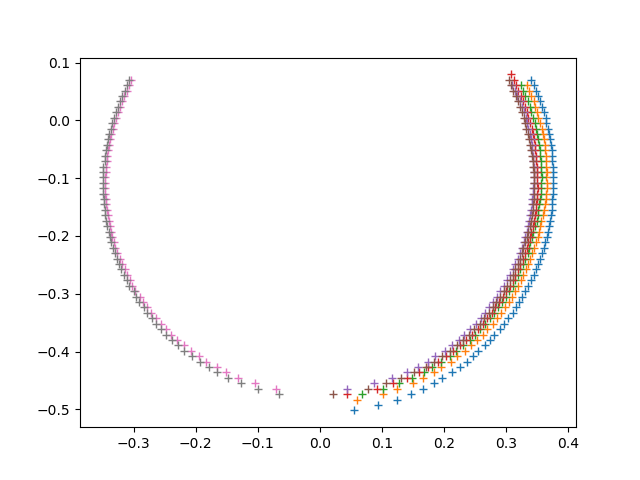

In [49]:
plt.figure()
xv = pack_x2.view();# xv.shape = -1,
yv = pack_y2.copy();# yv.shape = -1,
maskview = Si_mask.view(); maskview.shape = 8, 128
xv = np.ma.masked_array(xv, maskview)
# zv = z2.view(); zv.shape = -1,
# xv = x2[0]
# yv = y2[0]
for i in range(8):
    plt.plot(xv[i, :], yv[i, :], '+') # this show all pixels
    # plt.plot(xv[i, :54], yv[i, :54], '+')

<IPython.core.display.Javascript object>


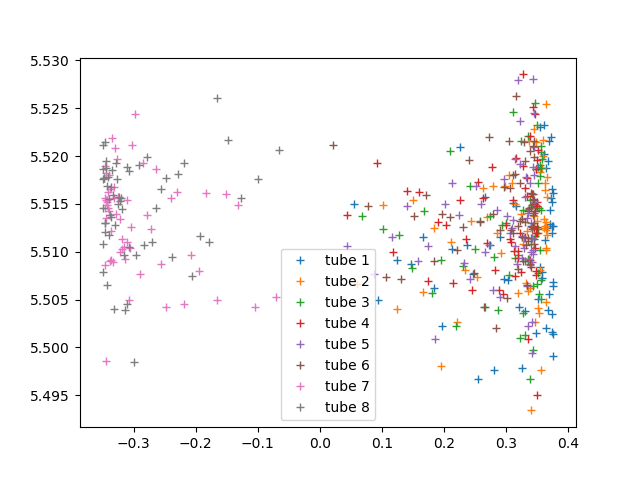

In [50]:
plt.figure()
xv = pack_x2.view();# xv.shape = -1,
yv = pack_y2.copy();# yv.shape = -1,
zv = pack_z2.view(); # zv.shape = -1,
xv = np.ma.masked_array(xv, maskview)
# xv = x2[0]
# yv = y2[0]
for i in range(8):
    plt.plot(xv[i, :], zv[i, :], '+', label = 'tube %s' % (i+1,))
plt.legend()